<br>

<h1 style="text-align:center;"> Task 13: Integrating the Computer Vision Pipeline </h1>


<br>

## Description

---

Once you have a working computer vision pipeline, and a working controller, you will need to integrate the two. You will need to modify the controller to accept the output of the computer vision pipeline as input. You will need to make sure that the ouput of the computer vision pipeline is in the correct format for the controller. The main goal for this task will be to inoculate the root tips present in multiple specimen plates.

You can use the same integration approach for both the PID controller and the RL controller, as both controllers will be accepting the same input and producing the same output. The input should be the co-ordinates of the root tips. You will need to determine the best way to relate the pixel co-ordinates of the root tips to the co-ordinates of the robot.

<br>

## Initial Setup

---

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import time
import tensorflow as tf
from typing import Tuple

# Don't use GPU
tf.config.set_visible_devices([], 'GPU')

# Add paths to required modules
task8_dir = os.path.join(os.getcwd(), '..', 'task8')
task10_dir = os.path.join(os.getcwd(), '..', 'task10')
task11_dir = os.path.join(os.getcwd(), '..', 'task11')
task12_dir = os.path.join(os.getcwd(), '..', 'task12')
sys.path.append(task8_dir)
sys.path.append(task10_dir)
sys.path.append(task11_dir)
sys.path.append(task12_dir)

# Import CV pipeline
from cv_pipeline import cv_inference

# Import PID components
from test_pid_controller import PIDTester
from pid_controller import PIDController
from ot2_env_wrapper import OT2Env
from train_ot2_rl import *

In [2]:
# Initialize environment and controller
env = OT2Env(render=True)

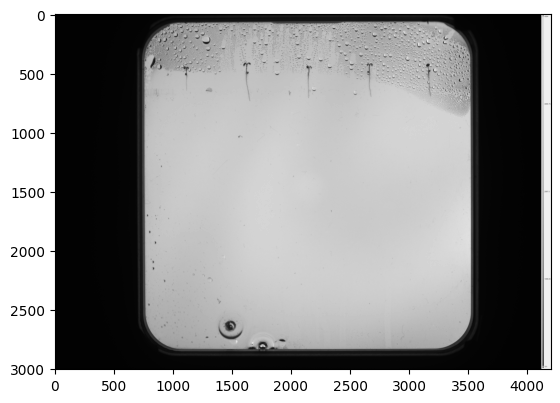

In [3]:
# Get image path
image_path = env.sim.get_plate_image()

# Load the image 
image = cv2.imread(image_path, 0)

# Plot the image in OT2
plt.imshow(image, cmap="gray")
plt.show()

<br>

# CV Pipeline

---

In [4]:
# CV Pipeline
image, mask, analyzer, root_df, root_data, tip_coordinates = cv_inference(image_path)
# image, mask, overlay, analyzer, root_df, root_data, tip_coordinates = cv_inference(image_path)

e:\University\2024-25b-fai2-adsai-SoheilMohammadpour231754\datalab_tasks\task13\..\task5\inference.py:200: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(
c:\Users\Soheil\.conda\envs\cv_rl_pipeline\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 272 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


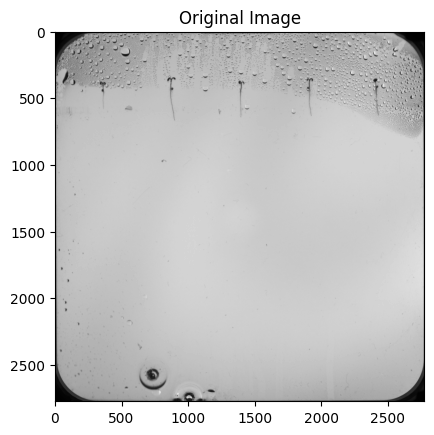

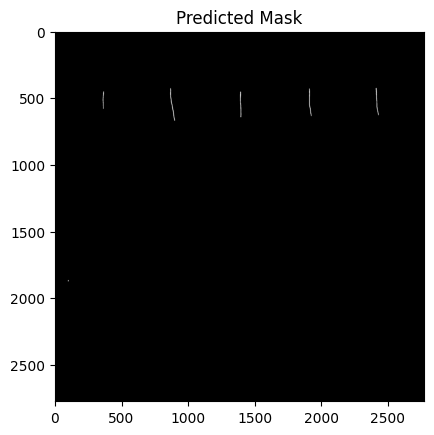

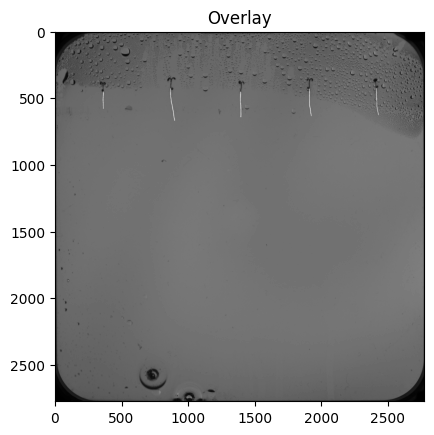

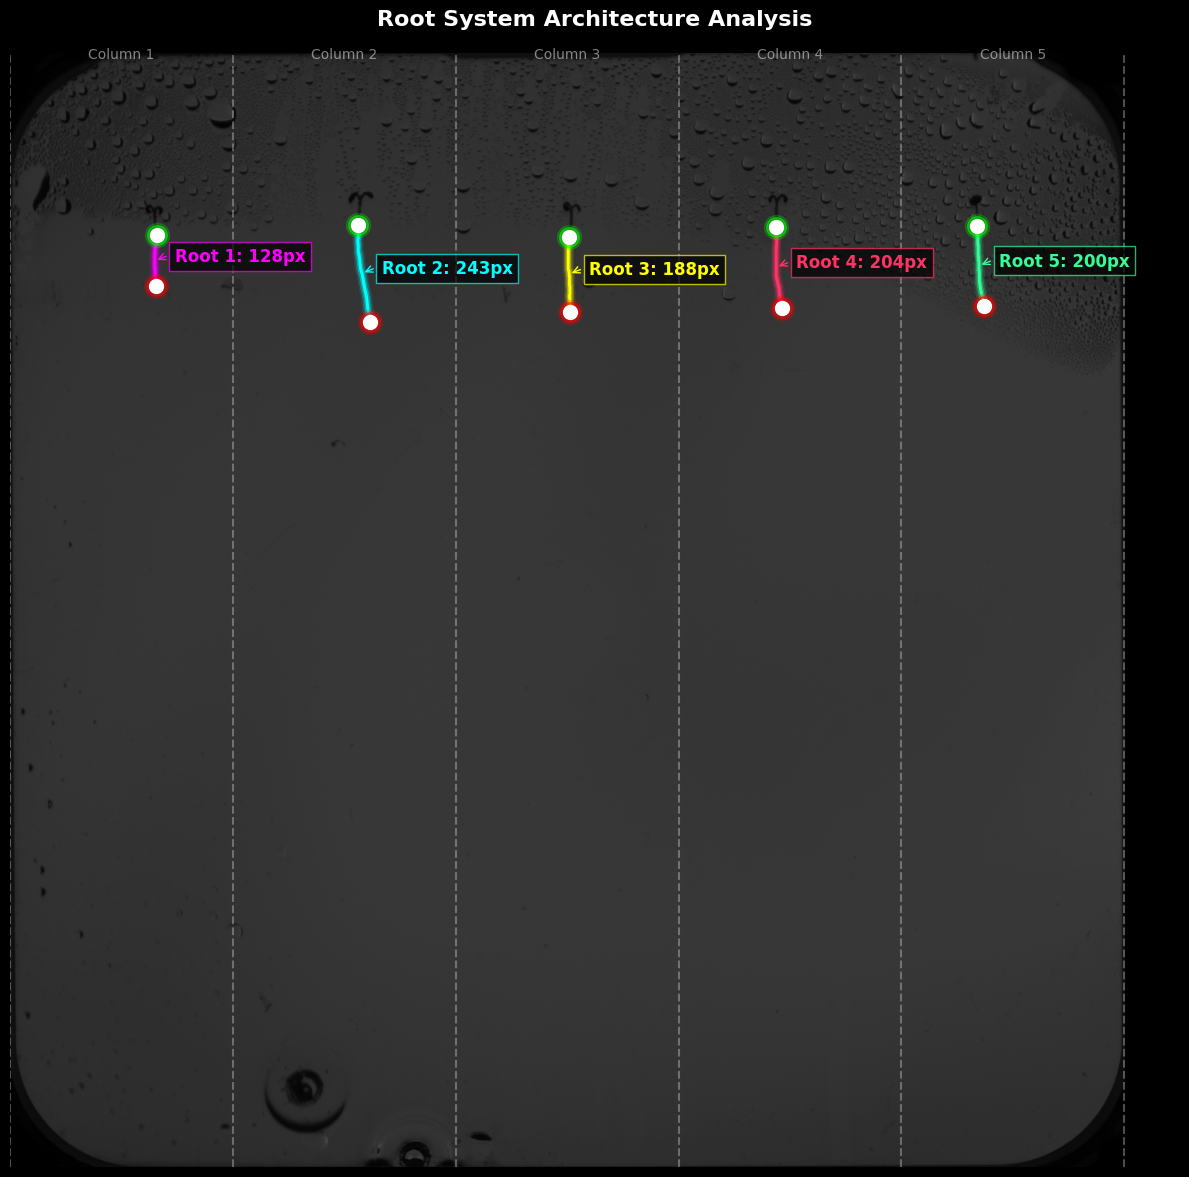

In [5]:
# Plot the image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

# Plot the mask
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask')
plt.show()

# Plot the overlay
overlay_image = cv2.addWeighted(image, 0.5, mask, 0.5, 0)
plt.imshow(overlay_image, cmap='gray')
plt.title('Overlay')
plt.show()

# Plot the RSA
analyzer.visualize_results(root_data, original_mask=mask, petri_dish=image)

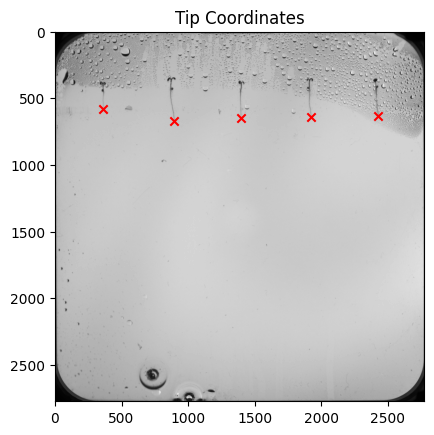

In [6]:
# Visualize the tip coordinates
plt.imshow(image, cmap='gray')
for tip in tip_coordinates:
    plt.scatter(tip['tip_x'], tip['tip_y'], c='red', marker='x')
plt.title('Tip Coordinates')
plt.show()


In [7]:
def convert_image_to_robot_coordinates(pixel_coords, image_dims):
    """
    Convert image pixel coordinates to robot coordinates with proper axis transformation
    
    Args:
        pixel_coords (tuple): (x,y) pixel coordinates from image
        image_dims (tuple): (width, height) of image in pixels
        
    Returns:
        list: [x,y,z] coordinates in robot space (meters)
    """
    # Starting position of the plate in robot space
    START_POSITION = [0.10775, 0.088 - 0.026, 0.11900000274181366]

    # Plate dimensions in mm
    PLATE_SIZE_MM = 150
    
    # Calculate conversion factors (mm/pixel)
    x_conversion = PLATE_SIZE_MM / image_dims[0]
    y_conversion = PLATE_SIZE_MM / image_dims[1]
    
    # Convert pixel coordinates to mm, with proper axis transformation
    # Note: We flip the y-axis here since image coordinates are top-down
    x_mm = pixel_coords[0] * x_conversion
    # y_mm = (image_dims[1] - pixel_coords[1]) * y_conversion  # Flip Y axis
    y_mm = pixel_coords[1] * y_conversion
    
    # Convert mm to meters
    x_m = x_mm / 1000
    y_m = y_mm / 1000
    
    # Transform to robot coordinates
    robot_x = START_POSITION[0] + y_m  # Swap X and Y
    robot_y = START_POSITION[1] + x_m
    robot_z = START_POSITION[2]
    
    return [robot_x, robot_y, robot_z]

In [8]:
# Convert each root tip position to robot coordinates
robot_coordinates = []
for pixel_coord in tip_coordinates:
    pixel_coord = list(pixel_coord.values())[1:]
    robot_coord = convert_image_to_robot_coordinates(pixel_coord, image_dims=image.shape)
    robot_coordinates.append(robot_coord)

robot_coordinates

[[0.13926351351351351, 0.08156756756756757, 0.11900000274181366],
 [0.14407432432432432, 0.11048648648648648, 0.11900000274181366],
 [0.14266891891891892, 0.13735135135135135, 0.11900000274181366],
 [0.14218243243243245, 0.1658918918918919, 0.11900000274181366],
 [0.14185810810810812, 0.19313513513513514, 0.11900000274181366]]

<br>

# PID Controller Pipeline

---

In [9]:
def move_to_targets(target_positions: list, render: bool = True) -> Tuple[bool, list]:
    """
    Move the robot through a sequence of target positions using PID control.
    
    Args:
        target_positions (list): List of target positions, each [x, y, z]
        render (bool): Whether to render the environment
        
    Returns:
        Tuple[bool, list]: Overall success flag and list of metrics for each movement
    """
    # Initialize environment and controller
    # env = OT2Env(render=render)
    
    # PID gains tuned for sub-millimeter precision
    gains = {
        'kp': [8.0, 8.0, 10.0],     # Reduced from [12.0, 12.0, 15.0]
        'ki': [0.2, 0.2, 0.3],      # Keep integral gains the same
        'kd': [0.5, 0.5, 0.8]       # Increased from [0.1, 0.1, 0.2]
    }
    
    controller = PIDController(kp=gains['kp'], ki=gains['ki'], kd=gains['kd'])
    
    # Constants
    dt = 1/240  
    max_steps = 1000
    all_metrics = []
    overall_success = True

    try:
        # Initial environment reset only once at the start
        obs, _ = env.reset()

        print("\n" + "="*50)
        print("🤖 Sequential Movement Details".center(50))
        print("="*50)        
        
        # Move to each target sequentially
        for i, target_pos in enumerate(target_positions):
            # Reset controller at the start of each movement
            controller.reset()
            
            target_pos = np.array(target_pos)
            success = False
            
            print(f"\n📍 Movement {i+1}/{len(target_positions)}:")
            
            # Get current position
            current_pos = np.array(env.sim.get_states()[f'robotId_{env.robot_id}']['pipette_position'])
            initial_distance = np.linalg.norm(target_pos - current_pos)
            
            # Add small delay to ensure system is stable
            time.sleep(0.1)
            
            print(f"  From: [{current_pos[0]:.4f}, {current_pos[1]:.4f}, {current_pos[2]:.4f}]")
            print(f"  To:   [{target_pos[0]:.4f}, {target_pos[1]:.4f}, {target_pos[2]:.4f}]")
            
            # Run control loop for this target
            distances = []
            injection_phase = False
            injection_complete = False
            
            for step in range(max_steps):
                current_pos = np.array(env.sim.get_states()[f'robotId_{env.robot_id}']['pipette_position'])
                distance = np.linalg.norm(target_pos - current_pos)
                distances.append(distance)
                
                # Add velocity scaling based on distance to target
                velocity_scale = min(1.0, max(0.3, distance * 10))  # Scale from 0.3 to 1.0
                
                at_target = (abs(target_pos[2] - current_pos[2]) < 0.001 and  
                           np.linalg.norm(target_pos[:2] - current_pos[:2]) < 0.001)
                
                if at_target and not injection_complete:
                    if not injection_phase:
                        # Start injection phase
                        injection_phase = True
                        print("  Starting injection...")
                    
                    # During injection, hold position
                    action = np.zeros(3, dtype=np.float32)
                    injection_action = 1
                    obs, reward, terminated, truncated, info = env.step(action, injection_action)
                    injection_complete = True
                    success = True
                    print("  💧 Water injected successfully!")
                    break
                else:
                    # Normal movement phase with velocity scaling
                    action = controller.compute(current_pos, target_pos, dt)
                    action = np.array(action, dtype=np.float32)
                    action *= velocity_scale  # Apply velocity scaling
                    action[2] *= 1.2  # Reduced Z multiplier from 1.5 to 1.2
                    injection_action = 0
                    obs, reward, terminated, truncated, info = env.step(action, injection_action)
                
                if terminated or truncated:
                    print(f"  ⚠️  Movement {i+1} terminated early")
                    break
            
            # Record metrics for this movement
            final_pos = np.array(env.sim.get_states()[f'robotId_{env.robot_id}']['pipette_position'])
            final_distance = distances[-1] if distances else float('inf')

            metrics = {
                'target_number': i+1,
                'success': success,
                'steps': step + 1,
                'initial_distance': initial_distance,
                'final_distance': final_distance,
                'path_efficiency': initial_distance / (sum(distances) / len(distances)) if distances else 0,
                'injection_complete': injection_complete
            }
            all_metrics.append(metrics)

            # Report metrics for this movement
            print(f"\n  📊 Movement {i+1} Results:")
            print(f"    Path Efficiency: {metrics['path_efficiency']:.3f}")
            print(f"    Final Distance: {metrics['final_distance']*1000:.2f}mm")
            print(f"    Steps Taken: {metrics['steps']}")
            print(f"    Success: {'✅' if metrics['success'] else '❌'}")
            print(f"    Injection: {'💧' if metrics['injection_complete'] else '❌'}")
            
            # Update overall success
            overall_success &= success
            
            # Optional: Add delay between movements
            time.sleep(0.5)
        
        # Move back to initial position
        initial_pos = np.array([0.10775, 0.088 - 0.026, 0.11900000274181366])
        print("\n📍 Returning to initial position...")
        
        for step in range(max_steps):
            current_pos = np.array(env.sim.get_states()[f'robotId_{env.robot_id}']['pipette_position'])
            distance = np.linalg.norm(initial_pos - current_pos)
            
            if distance < 0.001:
                print("  ✅ Reached initial position")
                break
                
            action = controller.compute(current_pos, initial_pos, dt)
            action = np.array(action, dtype=np.float32)
            action[2] *= 1.5
            obs, reward, terminated, truncated, info = env.step(action, 0)
            
            if terminated or truncated:
                print("  ⚠️ Return movement terminated early")
                break
        
        # Print final summary
        print("\n" + "="*50)
        print("📊 Movement Summary".center(50))
        print("="*50)
        successful_moves = sum(1 for m in all_metrics if m['success'])
        successful_injections = sum(1 for m in all_metrics if m['injection_complete'])
        print(f"Successful movements: {successful_moves}/{len(target_positions)}")
        print(f"Successful injections: {successful_injections}/{len(target_positions)}")
        
        return overall_success, all_metrics
        
    except Exception as e:
        print(f"\n❌ Error during movement sequence: {str(e)}")
        return False, all_metrics
        
    finally:
        # TODO
        # env.close()
        pass

# Example usage
if __name__ == "__main__":
    # Example list of target positions
    targets = robot_coordinates
        
    success, all_metrics = move_to_targets(targets)
    
    if success:
        print("\nDetailed metrics for each movement:")
        for metrics in all_metrics:
            print(f"\nTarget {metrics['target_number']}:")
            print(f"  Steps: {metrics['steps']}")
            print(f"  Path Efficiency: {metrics['path_efficiency']:.3f}")
            print(f"  Final Distance: {metrics['final_distance']*1000:.2f}mm")
            print(f"  Injection Complete: {'Yes' if metrics['injection_complete'] else 'No'}")
    else:
        print("\n❌ Some movements failed")


          🤖 Sequential Movement Details           

📍 Movement 1/5:
  From: [0.0730, 0.0890, 0.1190]
  To:   [0.1393, 0.0816, 0.1190]
  Starting injection...
  💧 Water injected successfully!

  📊 Movement 1 Results:
    Path Efficiency: 3.635
    Final Distance: 0.99mm
    Steps Taken: 150
    Success: ✅
    Injection: 💧

📍 Movement 2/5:
  From: [0.1385, 0.0822, 0.1190]
  To:   [0.1441, 0.1105, 0.1190]
  Starting injection...
  💧 Water injected successfully!

  📊 Movement 2 Results:
    Path Efficiency: 3.317
    Final Distance: 0.97mm
    Steps Taken: 125
    Success: ✅
    Injection: 💧

📍 Movement 3/5:
  From: [0.1435, 0.1097, 0.1190]
  To:   [0.1427, 0.1374, 0.1190]
  Starting injection...
  💧 Water injected successfully!

  📊 Movement 3 Results:
    Path Efficiency: 3.363
    Final Distance: 0.98mm
    Steps Taken: 128
    Success: ✅
    Injection: 💧

📍 Movement 4/5:
  From: [0.1433, 0.1366, 0.1190]
  To:   [0.1422, 0.1659, 0.1190]
  Starting injection...
  💧 Water injected succes

<br>

# RL Controller Pipeline

----

In [ ]:
# TODO